In [58]:
#pip install lxml


In [59]:
import pandas as pd
 
sp_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500_constituents = pd.read_html(sp_url, header=0)[0]
sp500_constituents.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Symbol                 503 non-null    object
 1   Security               503 non-null    object
 2   GICS Sector            503 non-null    object
 3   GICS Sub-Industry      503 non-null    object
 4   Headquarters Location  503 non-null    object
 5   Date added             503 non-null    object
 6   CIK                    503 non-null    int64 
 7   Founded                503 non-null    object
dtypes: int64(1), object(7)
memory usage: 31.6+ KB


In [60]:
sp500_constituents.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [61]:
import yfinance as yf

# 공백으로 종목을 구분하여 하나의 스트링으로 download 함수의 tickers에 넣어줌
# yfinance에서 '.' 처리를 못하는듯 함 '-'(dash)로 바꿔서 넣어줘야 함
tickers = ' '.join(sp500_constituents.Symbol.tolist()).replace('.', '-')

# 수정된 종목 리스트를 이용하여 데이터 다운로드
prices = yf.download(tickers=tickers, 
                     start='2020-01-01', end='2023-12-31',
                     interval='1d',
                     auto_adjust=True   # True: adjust all OHLC automatically
                     )
prices.info()

[*********************100%%**********************]  503 of 503 completed


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1006 entries, 2020-01-02 to 2023-12-29
Columns: 2515 entries, ('Close', 'A') to ('Volume', 'ZTS')
dtypes: float64(2019), int64(496)
memory usage: 19.3 MB


In [62]:
prices.head(5)

Close                                                    
                    A        AAL       AAPL       ABBV ABNB        ABT   
Date                                                                     
2020-01-02  83.637672  28.982893  73.152634  74.197632  NaN  80.889473  \
2020-01-03  82.294792  27.548195  72.441444  73.493340  NaN  79.903374   
2020-01-06  82.538078  27.219410  73.018677  74.073349  NaN  80.321999   
2020-01-07  82.791084  27.119778  72.675285  73.650780  NaN  79.875465   
2020-01-08  83.608482  27.737495  73.844360  74.172760  NaN  80.201057   

                                                           ...   Volume   
                 ACGL         ACN        ADBE         ADI  ...     WYNN   
Date                                                       ...            
2020-01-02  43.400002  197.680679  334.429993  111.776878  ...  3006500  \
2020-01-03  43.349998  197.351440  331.809998  109.809212  ...  1760500   
2020-01-06  43.520000  196.062744  333.709991  108.519073  ...  1357900   
2020-01-07  43.160000  191.829758  333.390015  110.987953  ...  1722100   
2020-01-08  42.730000  192.205994  337.869995  111.990356  ...  1176200   

                                                                            
                XEL       XOM     XRAY      XYL      YUM      ZBH    ZBRA   
Date                                                                        
2020-01-02  2915400  12456400  1556600   869500  1369900  1083972  387800  \
2020-01-03  2422500  17386900   910000   795100  1145500   992405  305300   
2020-01-06  2217100  20081900   751000   817300  1454100   972423  322600   
2020-01-07  1861100  17387700   792600   662200  1388600   934519  236300   
2020-01-08  4828900  15137700  1001500  1083200  1521500   936064  689600   

                              
               ZION      ZTS  
Date                          
2020-01-02  1528700  1576700  
2020-01-03  1215800  1274000  
2020-01-06  1217500  2334100  
2020-01-07  1450900  1224500  
2020-01-08  2396000  1766700  

[5 rows x 2515 columns]

In [63]:
# Find columns with Null values in the 'prices' DataFrame
# --> Because the timing of entry into the S&P500 is different, each column may have an initial null value.
#print(prices.columns[prices.isnull().any()])

# Drop the row with where all data is null
prices = prices.dropna(how='all')

prices = prices.stack().swaplevel().sort_index()
prices.columns = [col.lower().replace(' ', '_') for col in prices.columns]
prices.index.names = ['ticker', 'date']
prices.columns
#prices.to_csv('sp500_prices.csv')


Index(['close', 'high', 'low', 'open', 'volume'], dtype='object')

In [64]:
prices.columns

Index(['close', 'high', 'low', 'open', 'volume'], dtype='object')

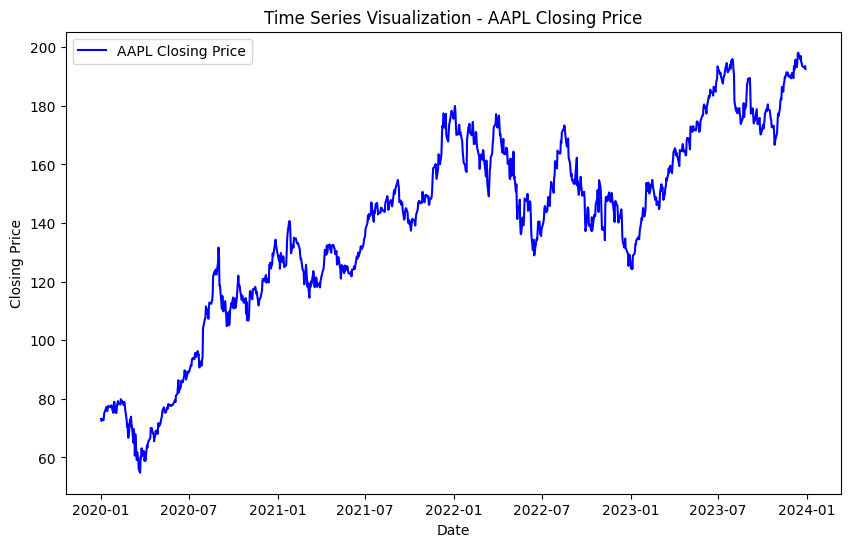

In [65]:
import matplotlib.pyplot as plt
import pandas as pd

# Example: Visualization of closing price time series data of 'AAPL' stock
plt.figure(figsize=(10, 6))
plt.plot(prices.loc['AAPL'].index, prices.loc['AAPL', 'close'], label='AAPL Closing Price', color='blue')
plt.title('Time Series Visualization - AAPL Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


In [66]:
# dollar volume
prices['dollar_vol'] = prices[['close', 'volume']].prod(axis=1)

# 21-day moving average of dollar volume (moving average of dollar volume for one month)
prices['dollar_vol_1m'] = (prices.dollar_vol.groupby('ticker').rolling(window=21).mean()).values
                           
# Calculate ranking of dollar trading volume 21-day moving average
prices['dollar_vol_rank'] = (prices.groupby('date')
                             .dollar_vol_1m
                             .rank(ascending=False))

/var/folders/_q/z89r9yv10wd_kg8vwlnwhb780000gn/T/ipykernel_61824/2242489208.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(prices.mfi.dropna())


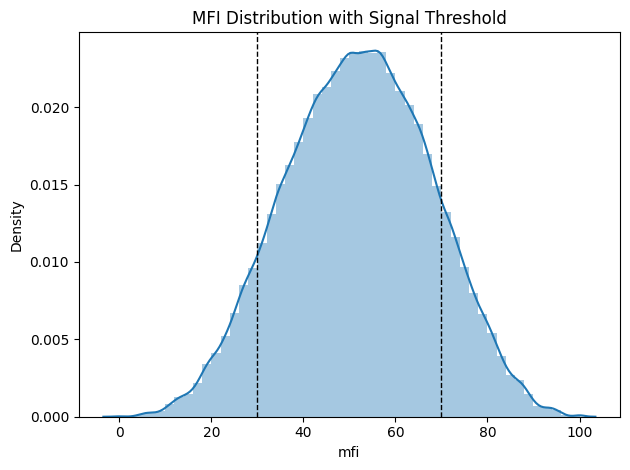

In [67]:
from talib import MFI
import seaborn as sns
 
#### calculate MFI 
prices['mfi'] = prices.groupby(level='ticker').apply(lambda x: MFI(x['high'], 
                                                                   x['low'], 
                                                                   x['close'], 
                                                                   x['volume'])).droplevel(0)

ax = sns.distplot(prices.mfi.dropna())
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('MFI Distribution with Signal Threshold')
plt.tight_layout();

In [72]:
# Calculate 'Lagged Returns'
# Lagged Returns : Stock return on the most recent n business days calculated as of t business days ago
# (1) Calculation of stock return on the most recent n business days
# (2) Removal of extreme return values
# (3) Prorated rate of return (geometric mean)
# (4) Shift the return variable to the current time by lag(t business days)

ndays = [1, 5, 10, 21, 42, 63]
q = 0.0001
for n in ndays:
    prices[f'return_{n}d'] = (prices.groupby(level='ticker').close
                                .pct_change(n)
                                .pipe(lambda x: x.clip(lower=x.quantile(q),
                                                       upper=x.quantile(1 - q)))
                                .add(1).pow(1/n).sub(1)
                                )
    
# prices.loc[prices.index.get_level_values('ticker').isin(['AAPL']), 
#            ['close']+[col for col in prices.columns if 'return_' in col]].head(10)


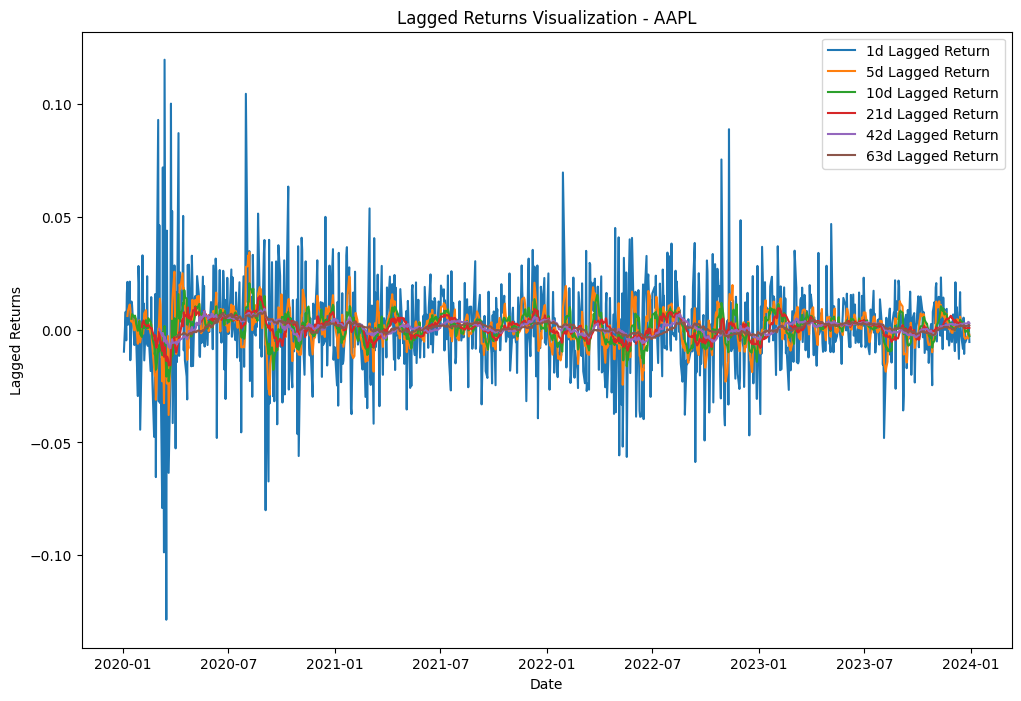

In [75]:
print(prices.info())
selected_date = '2021-01-02'
selected_ticker = 'AAPL'

# Check data for selected date and item
try:
    data_for_selected_date = prices.xs((selected_ticker, selected_date), level=(0, 1))
    print(data_for_selected_date)
except KeyError:
    print(f"No data found for {selected_ticker} on {selected_date}")


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 502628 entries, ('A', Timestamp('2020-01-02 00:00:00')) to ('ZTS', Timestamp('2023-12-29 00:00:00'))
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   close            502628 non-null  float64
 1   high             502628 non-null  float64
 2   low              502628 non-null  float64
 3   open             502628 non-null  float64
 4   volume           502628 non-null  float64
 5   dollar_vol       502628 non-null  float64
 6   dollar_vol_1m    492568 non-null  float64
 7   dollar_vol_rank  492568 non-null  float64
 8   mfi              495586 non-null  float64
 9   return_1d        502125 non-null  float64
 10  return_5d        500113 non-null  float64
 11  return_10d       497598 non-null  float64
 12  return_21d       492065 non-null  float64
 13  return_42d       481502 non-null  float64
 14  return_63d       470941 non-null  float64
dtypes: float64(1

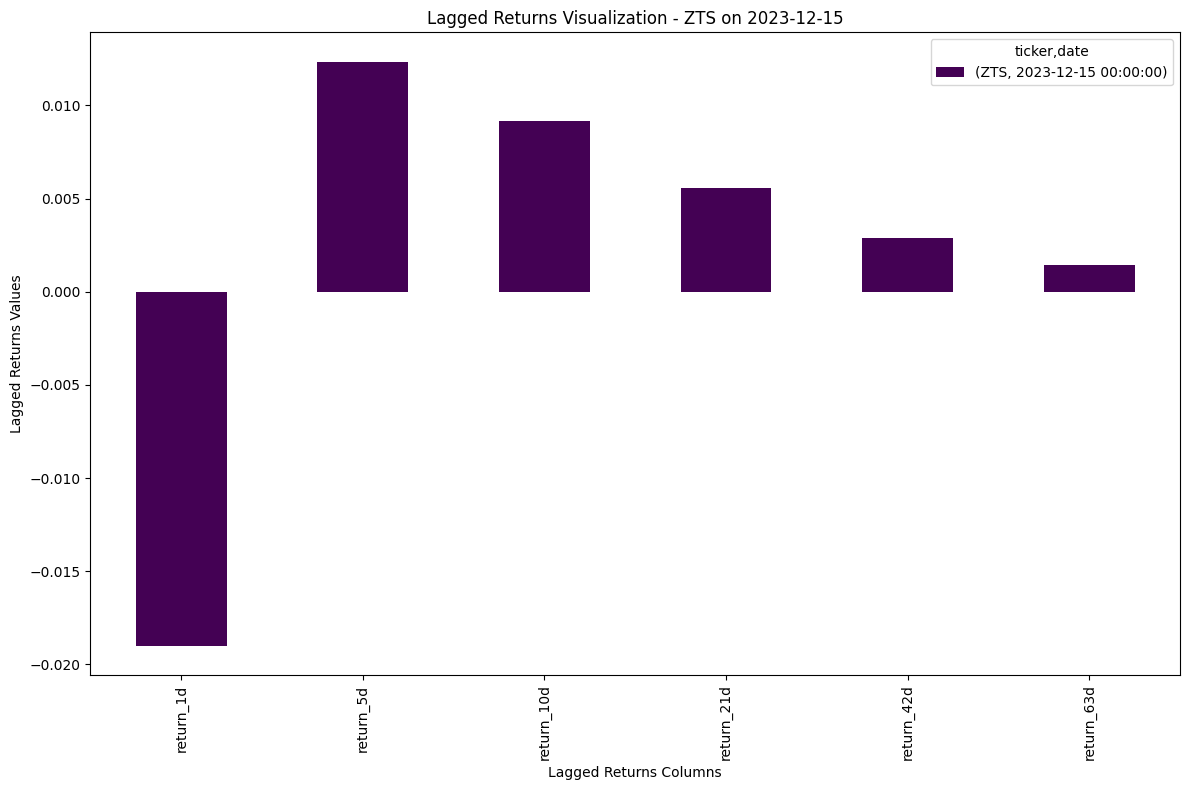

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

# Specify the date to select (ex: '2020-01-02')
selected_date = '2023-12-15'
selected_ticker = 'ZTS'

# Select columns starting with 'return_'
return_columns = [col for col in prices.columns if col.startswith('return_')]

# Extract only data from selected date and item, transpose columns to draw bar graph
ax = prices.xs((selected_ticker, selected_date), level=(0, 1))[return_columns].transpose().plot(kind='bar', figsize=(12, 8), colormap='viridis')

ax.set_xlabel('Lagged Returns Columns')
ax.set_ylabel('Lagged Returns Values')
ax.set_title(f'Lagged Returns Visualization - {selected_ticker} on {selected_date}')
plt.tight_layout()
plt.show()

